# Reinforcement Learning for Trading

The goal of reinforcement learning is to maximize the reward, in this case the profit on trading, the difference between the price we buy and the price we sell. We need to set our **enviroment** as a **Markov Desicion Process**, the state of enviroment is consequence of the previous state. We are training an **agent** that interacts with the enviroment, making decisions, called actions, at each state. We want to maximize the reward across the episodes. We want to find a **good strategy** or in other words, a good **policy**.<br>
If we know the rewards that each action will perform, then we can take actions to maximize that reward. The Q-learning will help us find the best action under certain states, since finding what actions to take might be complicated we will use deep learning.
### Each day (observation) is going to be a different step. 
For the train enviroment we will use 1612 steps since we are taking information from 2014 all to 2020 and for test enviroment we will use 150 steps, we can also call it days.
I will use 3 stocks: 
* Lowes, home improvement store.
* NVDA, nvidia which is a hardware tech company.
* JPM, J. P. Morgan Chase, basically a financial service company.
<br>

Remember we can buy (0), sell (1) or hold (2), in other words **3 possible actions**. The combinations of those possible actions are the amount of stocks to the power of the possible actions, straightforward 3³, that is 27 different actions. For example, we can buy all of our shares, or sell all but one, etc.<br>
As in the portfolio creation notebook we are going to have a 1000000 budget and we need to allocate it.<br>
For each stock **state** (we handle all 3 together) we include the current price, the amount of stocks owned and the current budget. 
The deep Q-network script was modified from the banana-navigator project from the Udacity Deep Reinforcement Learning implemented in **pytorch** (https://github.com/mauriciomani/Navigation-banana-collector). It was only modified the neural network adding a normalization layer, since our env is not normalized and would be good to implement.

In [9]:
import pandas as pd
import numpy as np
from collections import deque
#Be able to plot data
import matplotlib.pyplot as plt
#to save pytorch model
import torch
from env import Enviroment
import os
import seaborn as sns

In [2]:
path = "RL_data/"
codes = os.listdir(path)
all_df = pd.DataFrame()
for nombre in codes:
    try:
        df = pd.read_csv(path + nombre)
        df.set_index('Date', inplace = True)
        df.rename(columns = {'Adj Close': nombre}, inplace = True)
        all_df = all_df.join(df[[nombre]], how='outer')
    except:
        print("Warning: Stock: " + nombre + " Cannot be find with that name")
        pass
all_df.to_csv('rl_data.csv')

In [2]:
init_money = 1000000
num_stocks = 3
action_space = num_stocks ** 3
state_space = (num_stocks * 2) + 1

In [3]:
all_df = pd.read_csv('rl_data.csv', index_col = "Date")[["LOW.csv", "NVDA.csv", "JPM.csv"]]
all_df.head()

,LOW.csv,NVDA.csv,JPM.csv
Date,,,
2014-01-02,43.691132,14.996614,47.986519
2014-01-03,43.258118,14.816958,48.357494
2014-01-06,42.648346,15.015525,48.637775
2014-01-07,42.754391,15.261368,48.077198
2014-01-08,42.904621,15.469398,48.530605


In [4]:
portfolio_train = all_df.iloc[:-150]
portfolio_test = all_df.iloc[-150:]

In [5]:
env = Enviroment(portfolio_train, init_money)

### State space
We have the first 3 values representing the amount of stocks we have when the enviroment has been reset, the next 3 values represents the rounded adjusted closing price and finally we have the amount of cash we have, for total 7 values.<br>
For more information on how the enviroment works, kindly look at env.py script, that was specifically created for this.<br>
Below can be found the rewards for **random decisions** on the test set, this will also help us decide about current values on test using RL.

In [10]:
portfolio_train.shape

(1612, 3)

In [6]:
info = env.reset()
info

[0, 0, 0, 44.0, 15.0, 48.0, 1000000]

In [5]:
rewards = []
for i in range(2000):
    env = Enviroment(portfolio_test, init_money)
    state = env.reset()                                               # get the current state
    score = []                                                        # initialize the score
    while True:
        action = np.random.choice(list(range(0, action_space)))       # select an action
        env_info = env.step(action)                                   # send the action to the environment
        next_state = env_info[0]                                         # get the next state
        reward = env_info[1]                                           # get the reward
        done = env_info[-1]                                           # see if episode has finished
        score.append(reward)                                          # update the score
        state = next_state                                            # roll over the state to next time step
        if done:                                                      # exit loop if episode finished
            break
    rewards.append(sum(score))

[Text(0.5, 0, '')]

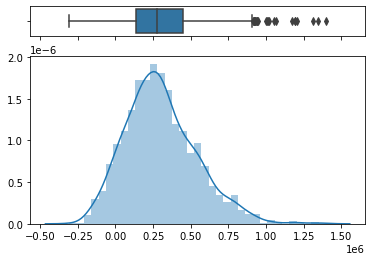

In [10]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(np.array(rewards), ax=ax_box)
sns.distplot(np.array(rewards), ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [11]:
#mean rewards
np.array(rewards).mean()

301329.7375

In [17]:
np.quantile(np.array(rewards), 0.83)

526759.4599999998

In [5]:
from dqn import Agent

env = Enviroment(portfolio_train, init_money)
agent = Agent(state_size=state_space, action_size=action_space, seed=12)

def dqn(n_episodes=2000, max_t=1615, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    #This store scores from each episodes
    scores = []
    #Check last 100 scores as said finished 
    scores_window = deque(maxlen=100)  
    #How epsilon starts, remeber should start big and gradually decay
    eps = eps_start
    #Iterate through number of episodes
    for i_episode in range(1, n_episodes+1):
        #start
        env_reset = env.reset()
        #state
        state = np.array(env_reset)
        #initialize score to 0
        score = 0
        #iterate through max number of trainings per episode
        for t in range(max_t):
            #return action 
            action = agent.act(state, eps)
            #take action
            env_reset = env.step(action)
            #store state produced by given action
            next_state = np.array(env_reset[0])
            #store reward
            reward = env_reset[1]
            #check if done
            done = env_reset[-1]
            #learn through sampling Replay Buffer
            agent.step(state, action, reward, next_state, done)
            #Set next_state as state
            state = next_state
            #Add to score the reward
            score += reward
            #if done break
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = dqn()

/home/mauriciomani/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Episode 50	Average Score: 3724580.00
Episode 100	Average Score: 4122233.98
Episode 150	Average Score: 4344864.96
Episode 200	Average Score: 6150775.77
Episode 250	Average Score: 7959622.78
Episode 300	Average Score: 7848065.07
Episode 350	Average Score: 8037804.36
Episode 400	Average Score: 8238148.47
Episode 450	Average Score: 8385414.88
Episode 500	Average Score: 10160874.12
Episode 550	Average Score: 12659686.98
Episode 600	Average Score: 17001017.24
Episode 650	Average Score: 19587159.61
Episode 700	Average Score: 19417294.34
Episode 750	Average Score: 18919795.63
Episode 800	Average Score: 16007325.14
Episode 850	Average Score: 16316898.67
Episode 900	Average Score: 18911518.05
Episode 950	Average Score: 18850770.45
Episode 1000	Average Score: 16477329.91
Episode 1050	Average Score: 15448314.29
Episode 1100	Average Score: 15409115.64
Episode 1150	Average Score: 14494309.73
Episode 1200	Average Score: 16205354.97
Episode 1250	Average Score: 18106246.02
Episode 1300	Average Score: 1

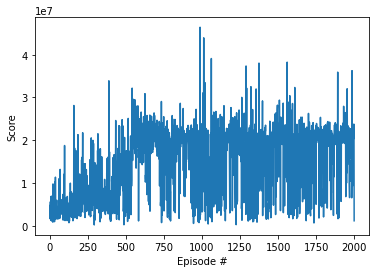

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [6]:
from dqn import Agent

filename_to_load = 'checkpoint.pth'
final_eps = 0.05

agent = Agent(state_size=state_space, action_size=action_space, seed=12)
#load the saved model from previous training
agent.qnetwork_local.load_state_dict(torch.load(filename_to_load))

/home/mauriciomani/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


<All keys matched successfully>

In [7]:
env = Enviroment(portfolio_test, init_money)
env_info = env.reset()
state = np.array(env_info)          
score = 0                                         
while True:
    action = agent.act(state, eps=final_eps)      
    env_info = env.step(action)    
    next_state = np.array(env_info[0]) 
    reward = env_info[1]                  
    done = env_info[-1]                 
    score += reward                               
    state = next_state                            
    if done:
        print("Your final score is:")
        print(score)
        break

Your final score is:
533038.0


### Bigger than 83% form 2000 rewards
Remember that doing the random approximation we do not have any strategy to follow, which we have in the reinforcement learning scenario.<br>
#### What can we do next?
We can connect a stocks historical data API, like the one has been used in this repo to make decisions on those 3 stocks. Basically we only need the adjusted closing price, and that is it, we can make daily decisions.